In [2]:
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.compiler import lib

import sys
import os

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.model import Model
from src.functions import *

In [34]:
def getFileNames(baseDirectory, modelName, setAndMetric, noiseType, fileParamName, paramValue, averageCount):
    fileNames = []
    for i in range(1,averageCount+1):
        fileNames.append(baseDirectory + modelName + setAndMetric + noiseType + fileParamName + str(paramValue) + "_" + str(i))
    return fileNames

#Merge the results from the files in list. The files need to have the same dimension
def loadArray(fileNames="temp"):
    if type(fileNames) is list and len(fileNames)==1:
        fileNames = fileNames[0]

    if type(fileNames) is list:
        file = open(fileNames[0], "rb")
        array = np.load(file).reshape((-1,1))
        file.close()
        for fn in fileNames[1:]:
            file = open(fn, "rb")
            conAcc = np.load(file).reshape((-1,1))
            array = np.concatenate((array, conAcc), axis=1)
            file.close()
        
    else:
        file = open(fileNames, "rb")
        array = np.load(file)
        file.close()

    return array

def plotData(ax, n_epochs, loss, stdMode, metricMode):
    if np.ndim(loss) == 2:
        match metricMode:
            case "mean":
                mean = np.mean(loss, axis=1)
            case "highest":
                currentHighest = -np.inf
                for i in range(np.shape(loss)[-1]):
                    highest = loss[:,i][-1]
                    if highest > currentHighest:
                        currentHighest = highest
                        mean = loss[:,i]
            case "lowest":
                currentLowest = np.inf
                for i in range(np.shape(loss)[-1]):
                    lowest = loss[:,i][-1]
                    if lowest < currentLowest:
                        currentLowest = lowest
                        mean = loss[:,i]
            case _:
                print("Error: Only accepts 'mean', 'highest' and 'lowest' as metric modes")
                raise ValueError
            
        std = np.std(loss, axis=1)
    else:
        mean = loss
        std = np.zeros_like(loss)
    match stdMode:
        case "bar":
            ax.errorbar(np.linspace(0, n_epochs, len(mean)), mean, std, elinewidth=1.2, capsize=5, capthick=1.5)
        case "line":
            ax.plot(np.linspace(0, n_epochs, len(mean)), mean)
            ax.fill_between(np.linspace(0, n_epochs, len(mean)), mean-std, mean+std, alpha=.2)
        case _:
            ax.plot(np.linspace(0, n_epochs, len(mean)), mean)

In [14]:
#Assumes models are saved in standard format
def displayResults(baseDirectory, modelName, consideredParams = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11] ,figsize=(14,6), n_epochs = 100000, 
                      combinePlots = False, useLogLoss = True, customTitle = None, noiseType = "gaussian", averageCount = 5, stdMode = "bar", metricMode = "mean", clipEpochsAt = None):
    if stdMode and stdMode not in ["bar", "line"]:
        print("Error: Std mode needs to be None, 'bar' or 'line'")                                   
    if noiseType not in ["gaussian", "bitflip"]:
        print("Error: Noise type needs to be 'gaussian' or 'bitflip'")
        return -1
    
    paramName = "std"
    fileParamName = "_std"
    if noiseType == "bitflip":
        paramName = "Flip rate"
        fileParamName = "_fliprate_"
    
    if clipEpochsAt:
        pass    #TODO

    f = 4   #Factor which avoids index of of bounds when combining plots
    if combinePlots:
        fig, axs = plt.subplots(1,2, figsize=figsize)
        f = 2
    else:
        if figsize == (14,6):
            figsize = (14,12)
        fig, axs = plt.subplots(2,2, figsize=figsize)
        axs = [axs[0][0], axs[0][1], axs[1][0], axs[1][1]] #Flatten

    legends = [[],[],[],[]]

    for p in consideredParams:
        #Training Loss
        legends[0].append("Training - " + paramName + " = "+str(p))
        fileNames = getFileNames(baseDirectory, modelName, "_train_loss_", noiseType, fileParamName, p, averageCount)
        loss = loadArray(fileNames)
        if useLogLoss:
            loss = np.log10(loss+1)
        plotData(axs[0], n_epochs, loss, stdMode, metricMode)
        #Training Accuracy
        legends[1].append("Training - " + paramName + " = "+str(p))
        fileNames = getFileNames(baseDirectory, modelName, "_train_acc_", noiseType, fileParamName, p, averageCount)
        acc = loadArray(fileNames)
        plotData(axs[1], n_epochs, acc, stdMode, metricMode)
        #Validation Loss
        legends[2%f].append("Validation - " + paramName + " = "+str(p))
        fileNames = getFileNames(baseDirectory, modelName, "_val_loss_", noiseType, fileParamName, p, averageCount)
        loss = loadArray(fileNames)
        if useLogLoss:
            loss = np.log10(loss+1)
        plotData(axs[2%f], n_epochs, loss, stdMode, metricMode)
        #Validation Accuracy
        legends[3%f].append("Validation - " + paramName + " = "+str(p))
        fileNames = getFileNames(baseDirectory, modelName, "_val_acc_", noiseType, fileParamName, p, averageCount)
        acc = loadArray(fileNames)
        plotData(axs[3%f], n_epochs, acc, stdMode, metricMode)

    if combinePlots:
        axs[0].set_title("Loss")
        if useLogLoss:
            axs[0].set(xlabel="Epochs", ylabel="Logarithmic Loss [log(loss+1)]")
        else:  
            axs[0].set(xlabel="Epochs", ylabel="Loss")
        axs[0].legend(legends[0]+legends[1]+legends[2]+legends[3])#
        axs[1].set_title("Accuracy")
        axs[1].set(xlabel="Epochs", ylabel="Accuracy")
        axs[1].legend(legends[0]+legends[1]+legends[2]+legends[3])
    else:
        axs[0].set_title("Training Loss")
        if useLogLoss:
            axs[0].set(xlabel="Epochs", ylabel="Logarithmic Loss [log(loss+1)]")
        else:  
            axs[0].set(xlabel="Epochs", ylabel="Loss")
        axs[0].legend(legends[0])
        axs[1].set_title("Training Accuracy")
        axs[1].set(xlabel="Epochs", ylabel="Accuracy")
        axs[1].legend(legends[1])
        axs[2].set_title("Validation Loss")
        if useLogLoss:
            axs[2].set(xlabel="Epochs", ylabel="Logarithmic Loss [log(loss+1)]")
        else:  
            axs[2].set(xlabel="Epochs", ylabel="Loss")
        axs[2].legend(legends[2])
        axs[3].set_title("Validation Accuracy")
        axs[3].set(xlabel="Epochs", ylabel="Accuracy")
        axs[3].legend(legends[3])
    if customTitle:
        fig.suptitle(customTitle)
    else:
        fig.suptitle(modelName)


    #Check that combine plots work correctly on overtraining

    #There are a shit ton of files. Consider compressing results into model/set/noiseModel files

## Displaying bit flip results from 0 to 0.1 with highest metrics

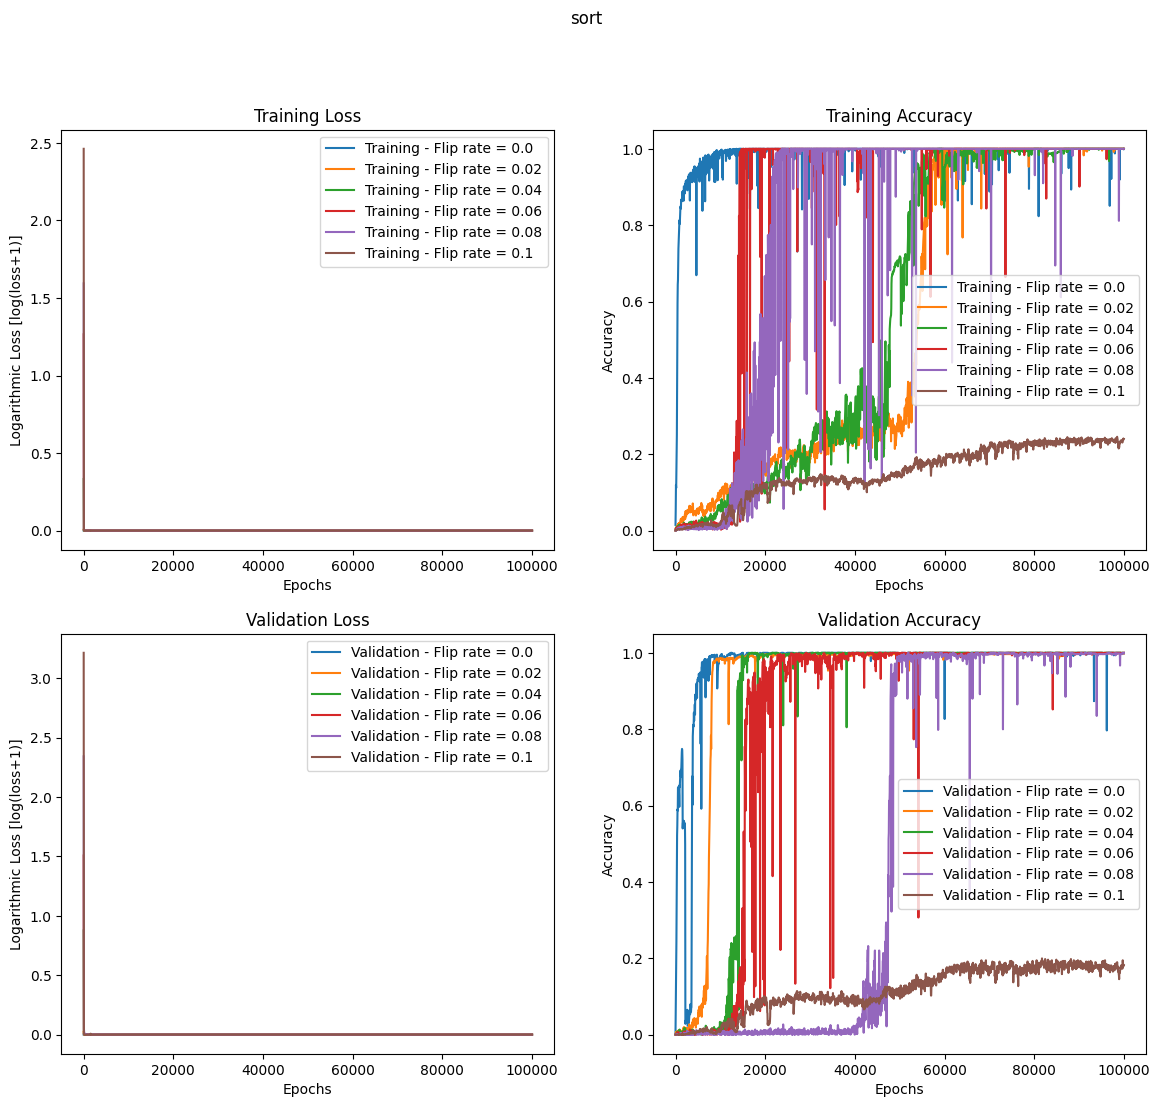

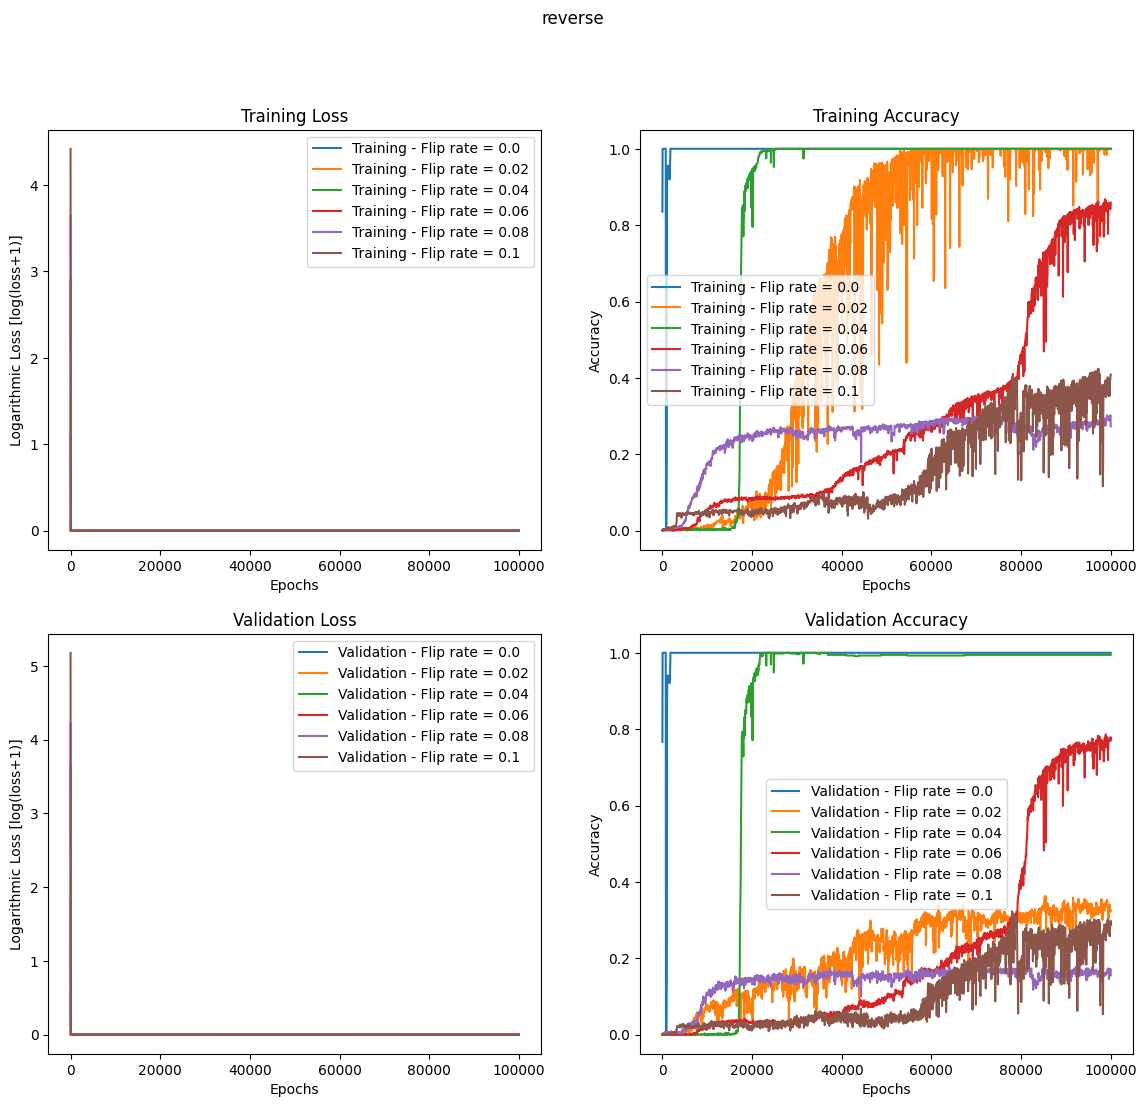

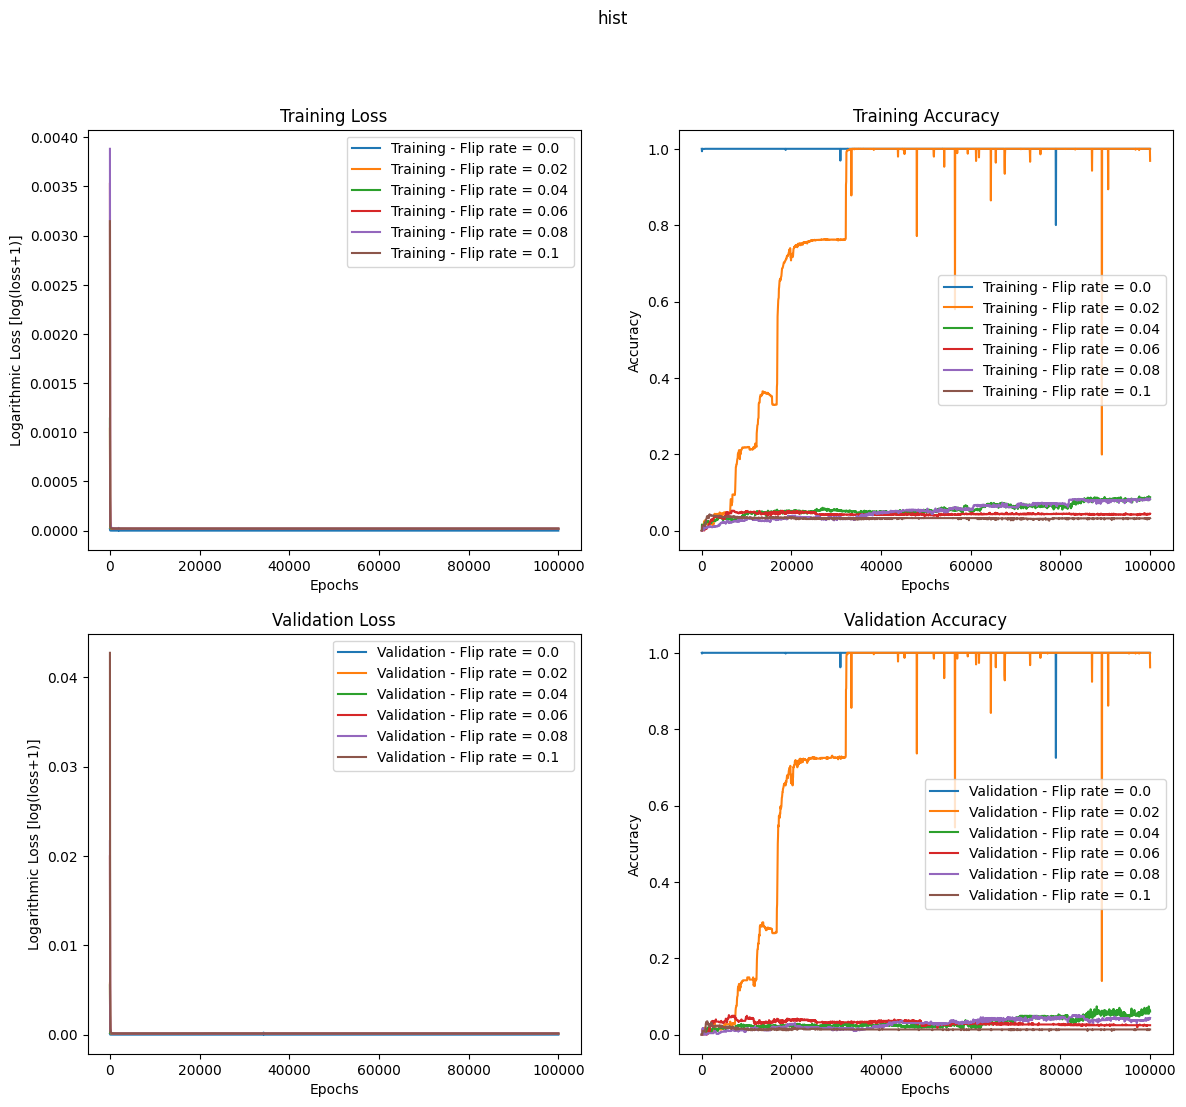

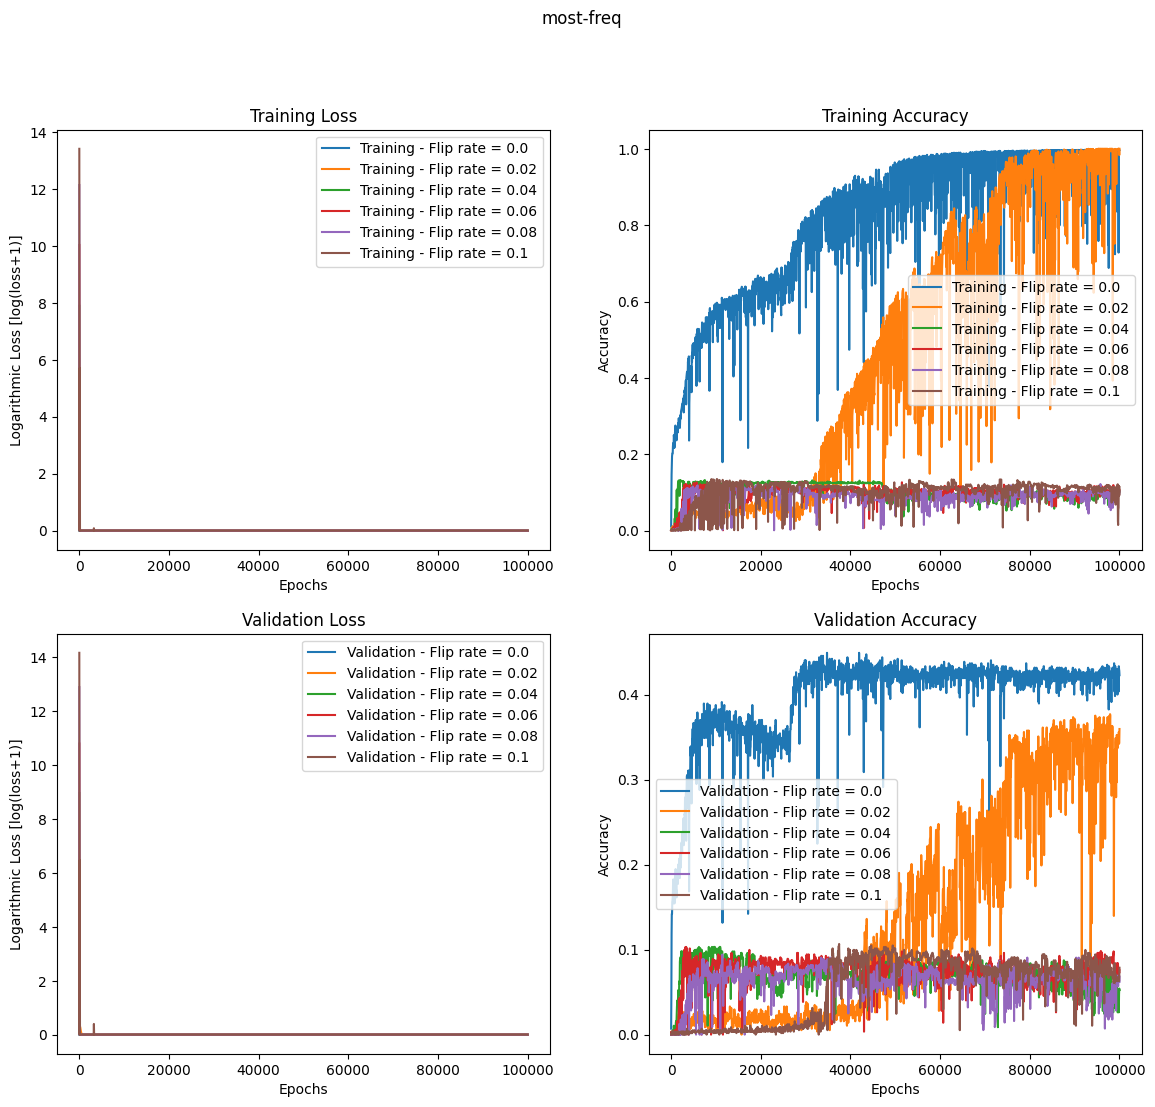

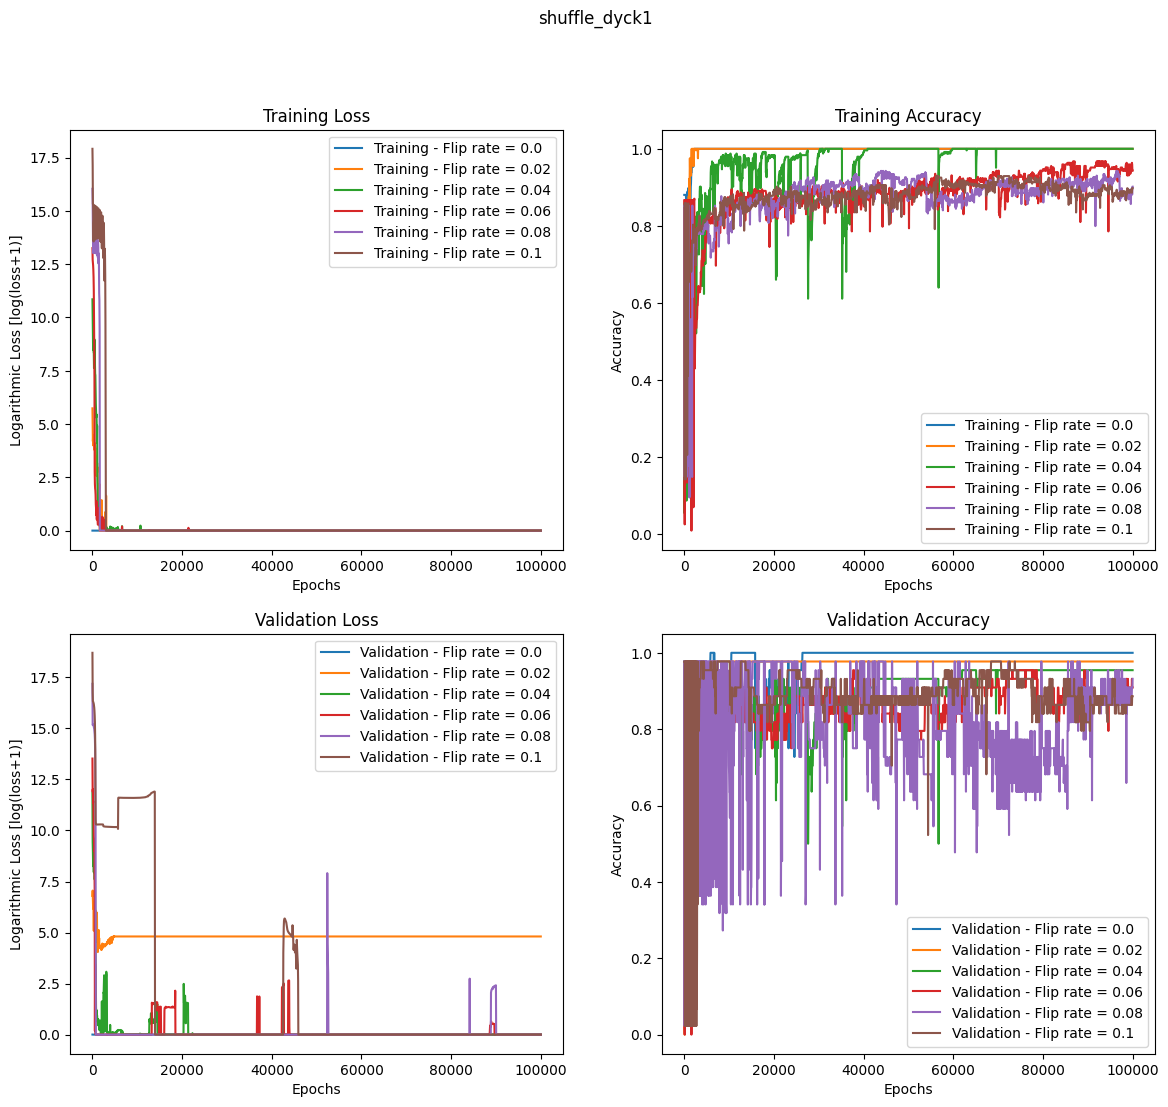

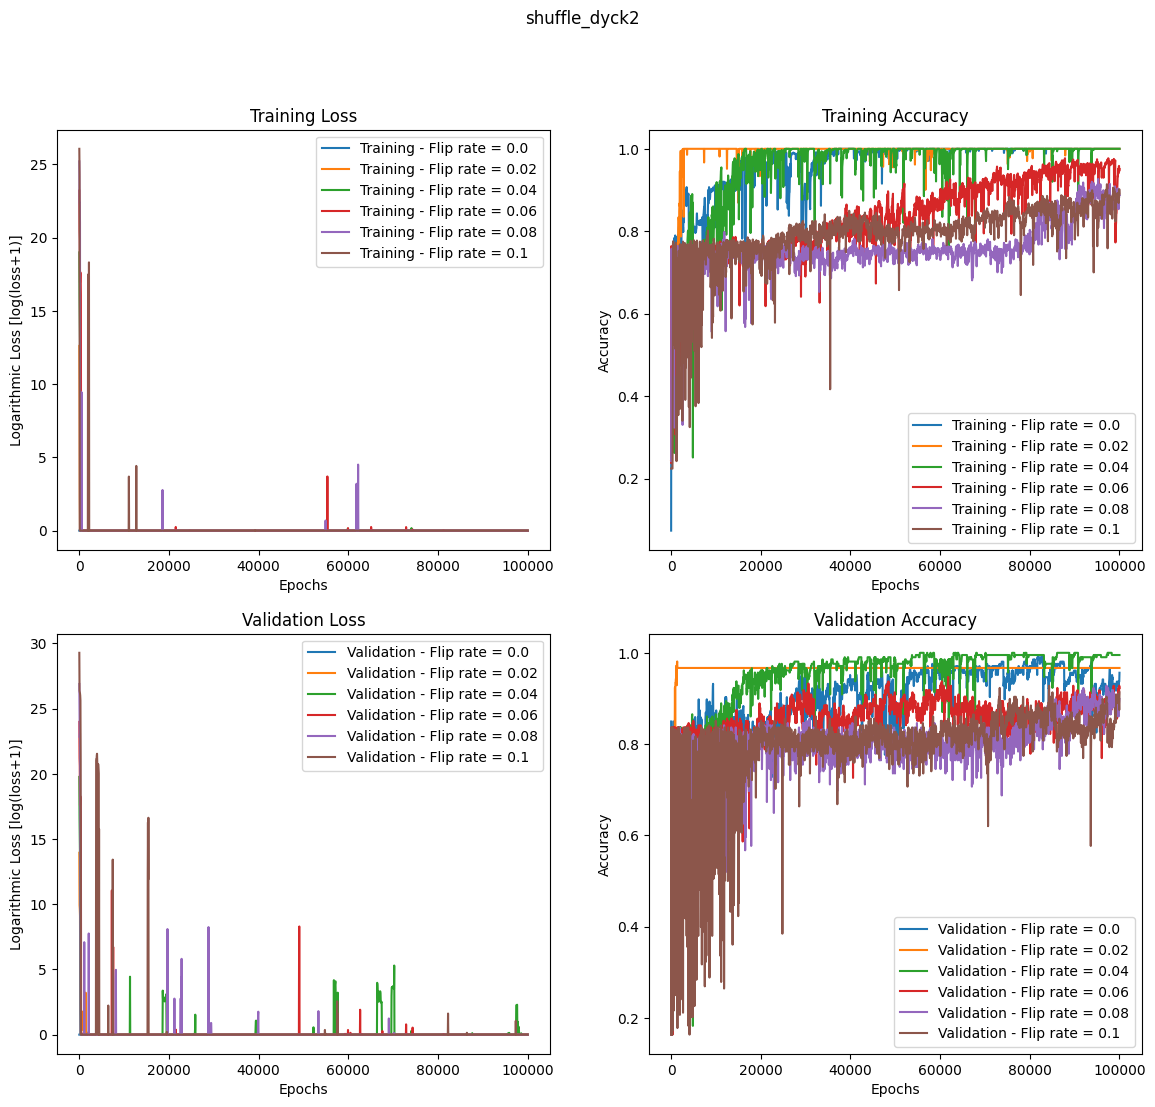

In [30]:
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/noiseTrainingBitFlip/"
stdMode = None
displayResults(baseDirectory, "sort", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, metricMode="highest", useLogLoss=True)
displayResults(baseDirectory, "reverse", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, metricMode="highest", useLogLoss=True) 
displayResults(baseDirectory, "hist", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, metricMode="highest", useLogLoss=True)
displayResults(baseDirectory, "most-freq", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, metricMode="highest", useLogLoss=True) 
displayResults(baseDirectory, "shuffle_dyck1", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, metricMode="highest", useLogLoss=True)
displayResults(baseDirectory, "shuffle_dyck2", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, metricMode="highest", useLogLoss=True)

## Displaying bit flip results from 0 to 0.1 with lowest metrics

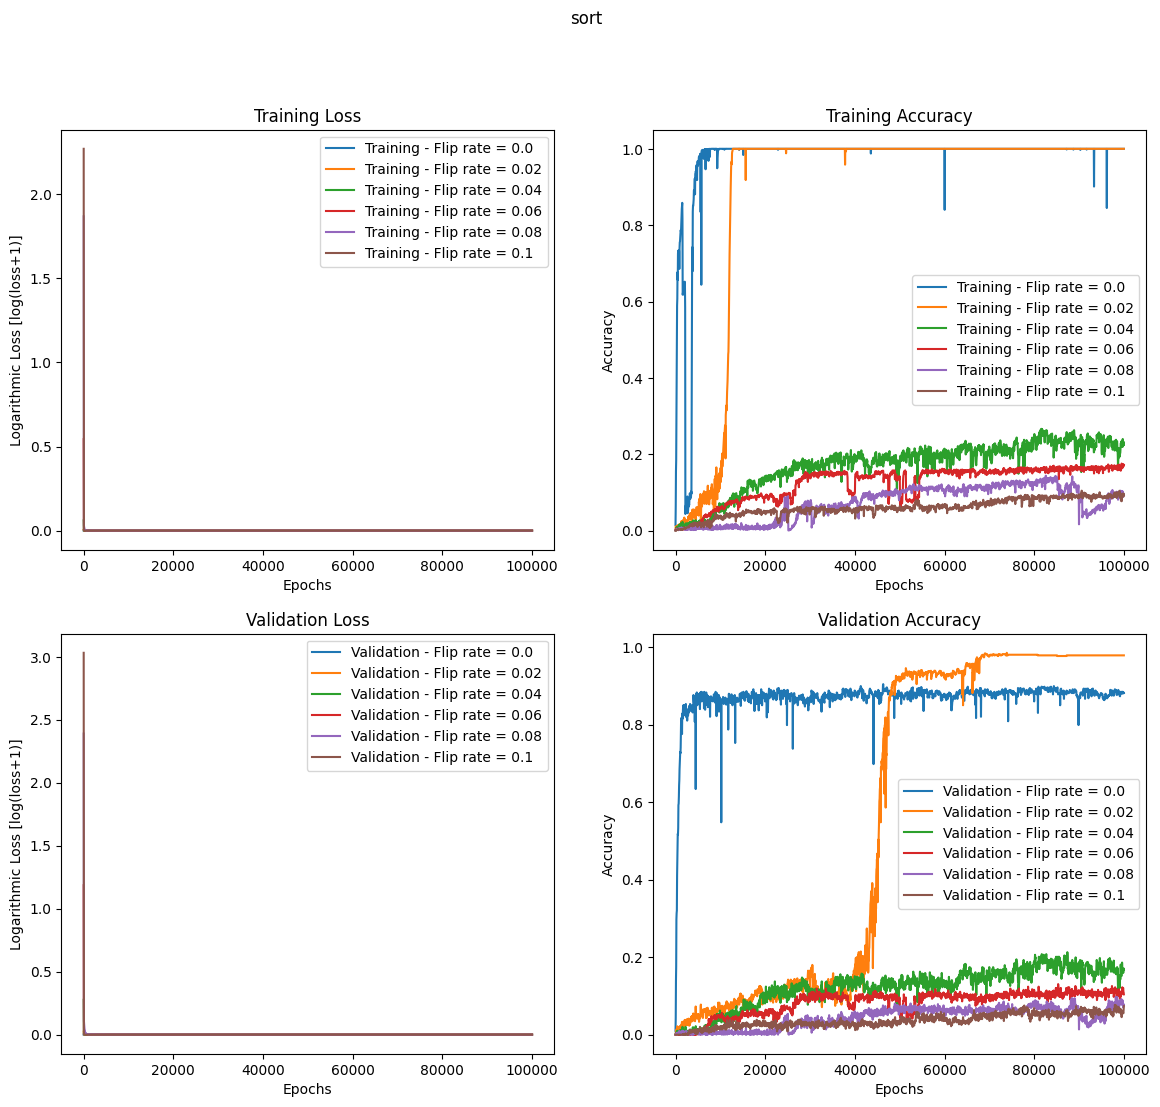

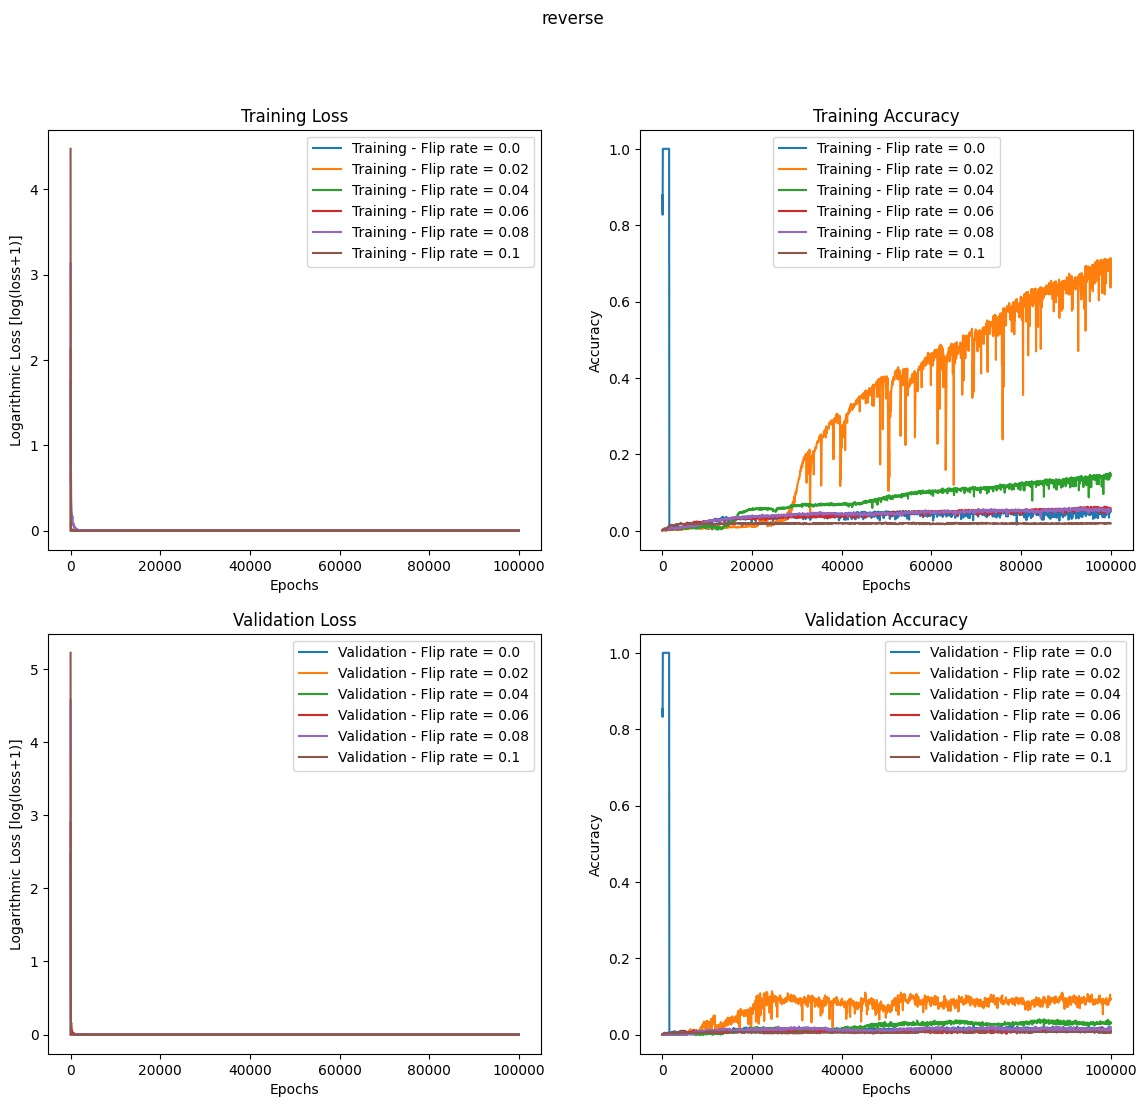

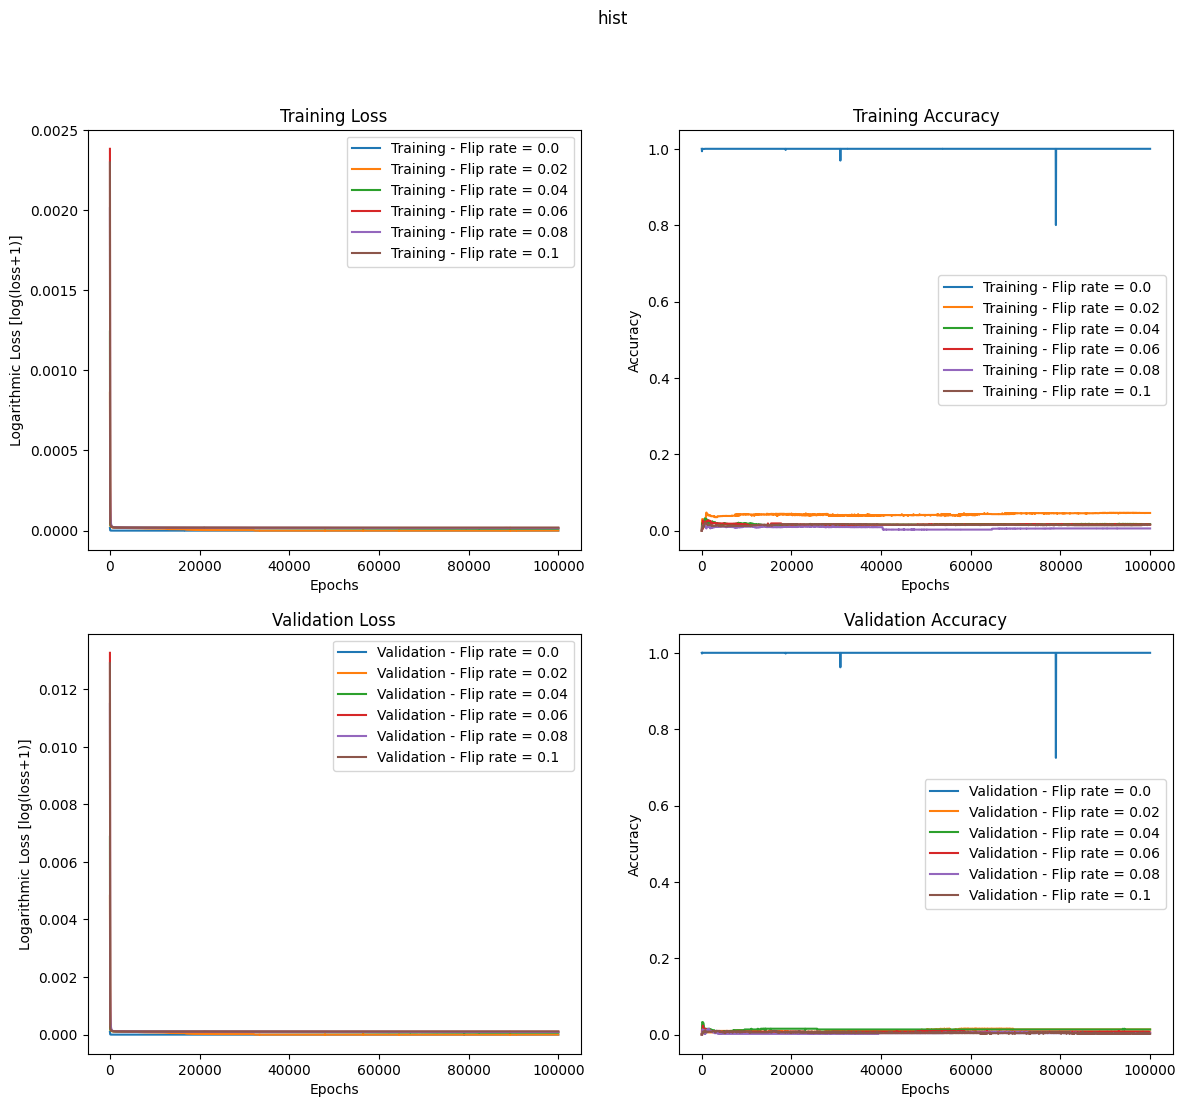

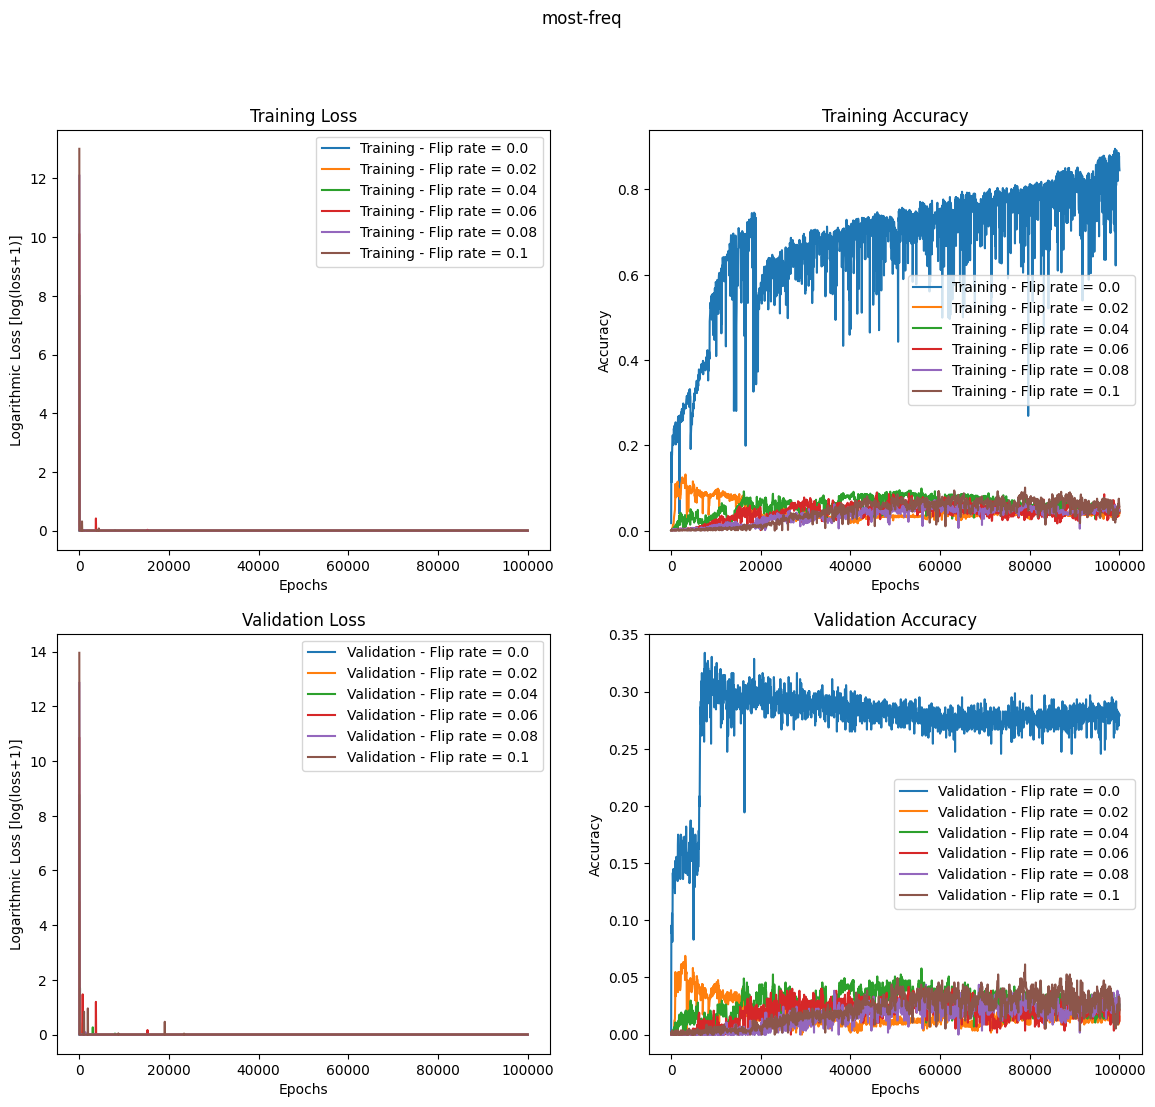

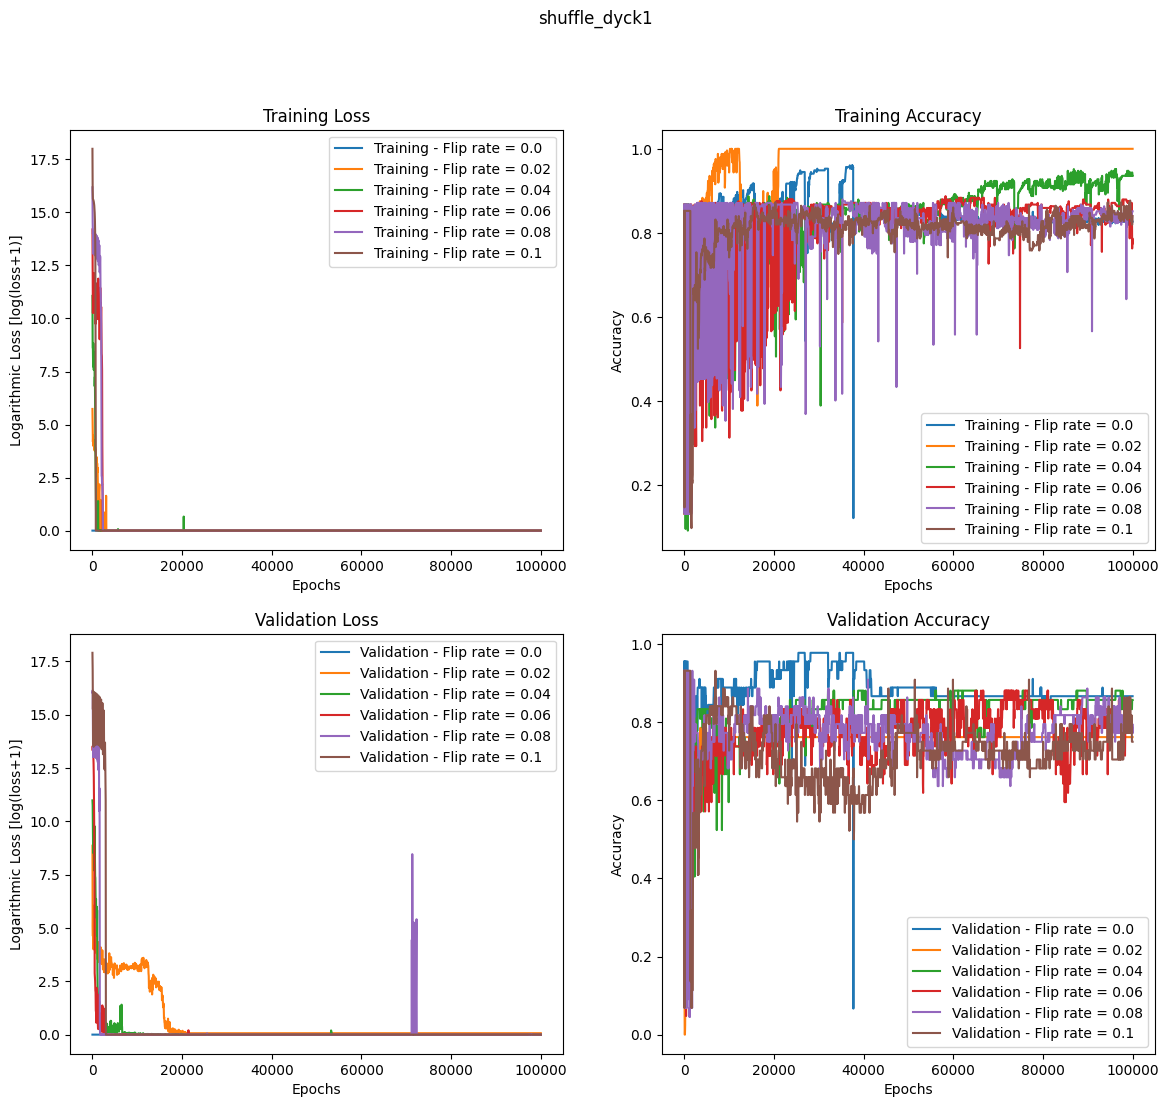

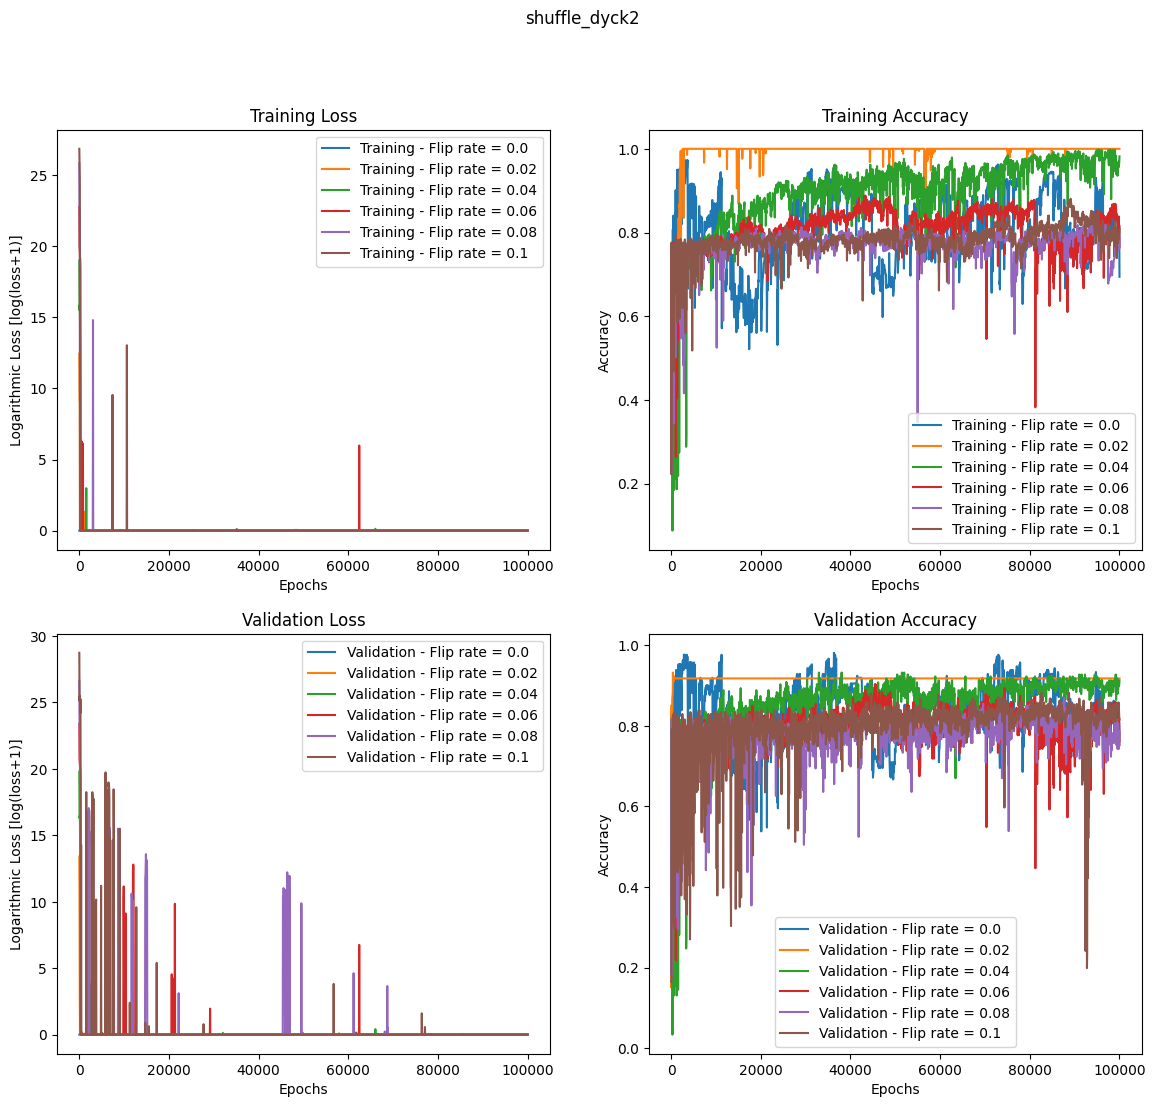

In [35]:
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/noiseTrainingBitFlip/"
stdMode = None
displayResults(baseDirectory, "sort", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, metricMode="lowest", useLogLoss=True)
displayResults(baseDirectory, "reverse", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, metricMode="lowest", useLogLoss=True) 
displayResults(baseDirectory, "hist", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, metricMode="lowest", useLogLoss=True)
displayResults(baseDirectory, "most-freq", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, metricMode="lowest", useLogLoss=True) 
displayResults(baseDirectory, "shuffle_dyck1", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, metricMode="lowest", useLogLoss=True)
displayResults(baseDirectory, "shuffle_dyck2", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, metricMode="lowest", useLogLoss=True)

## Displaying bit flip results from 0 to 0.1 with mean metrics

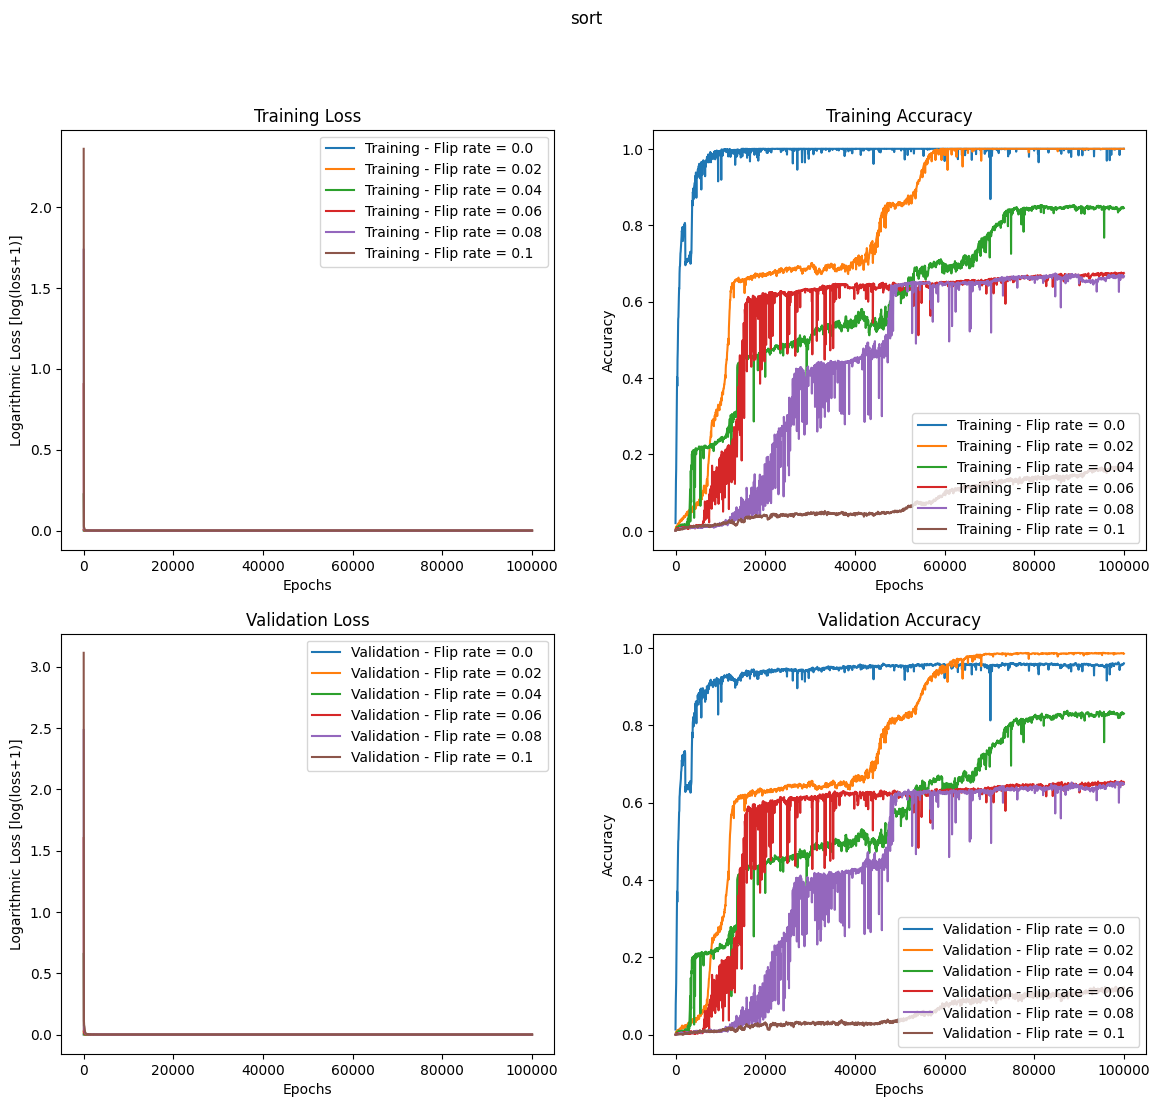

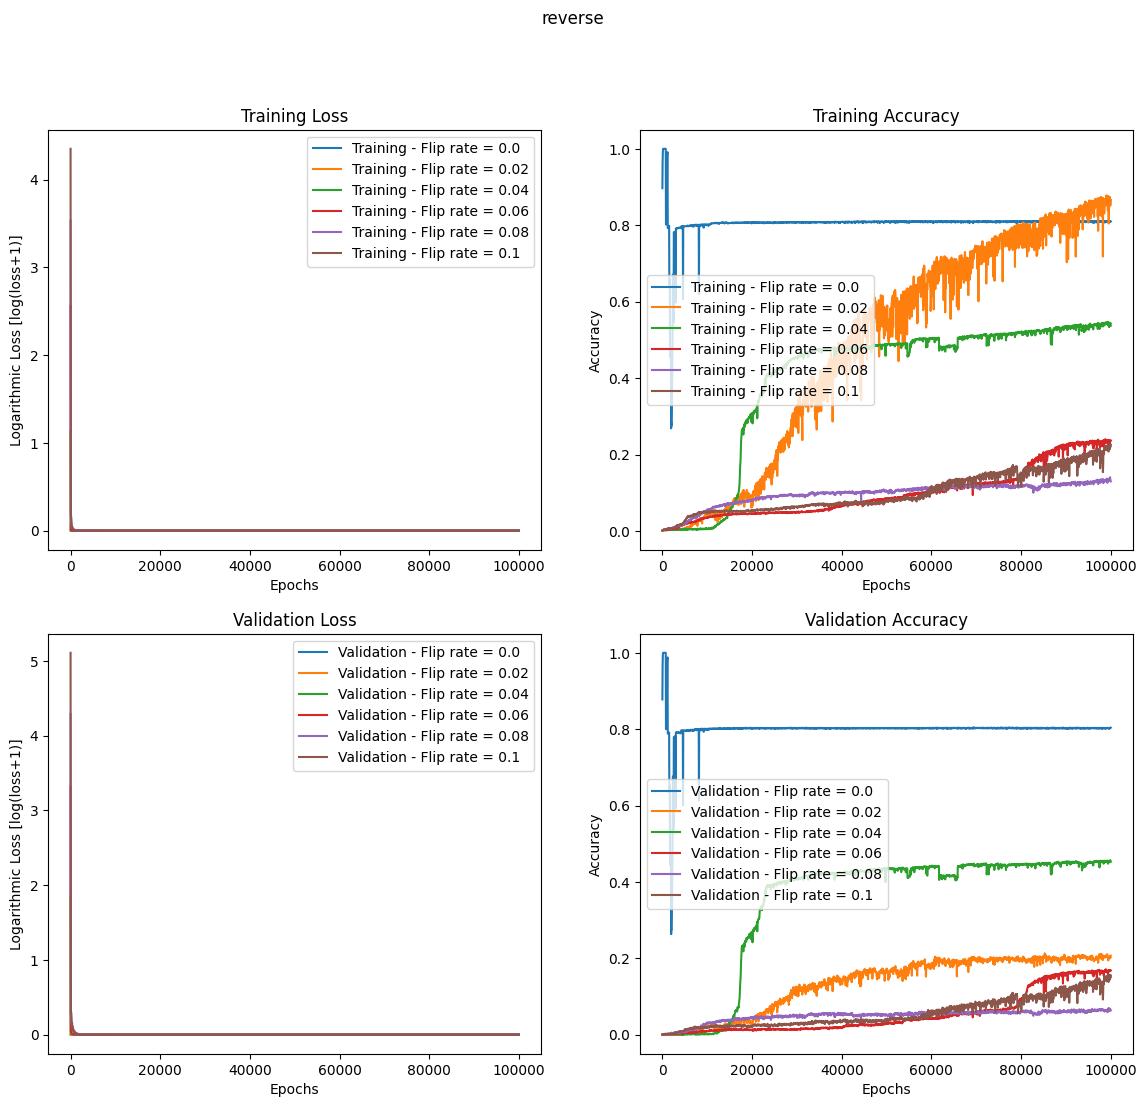

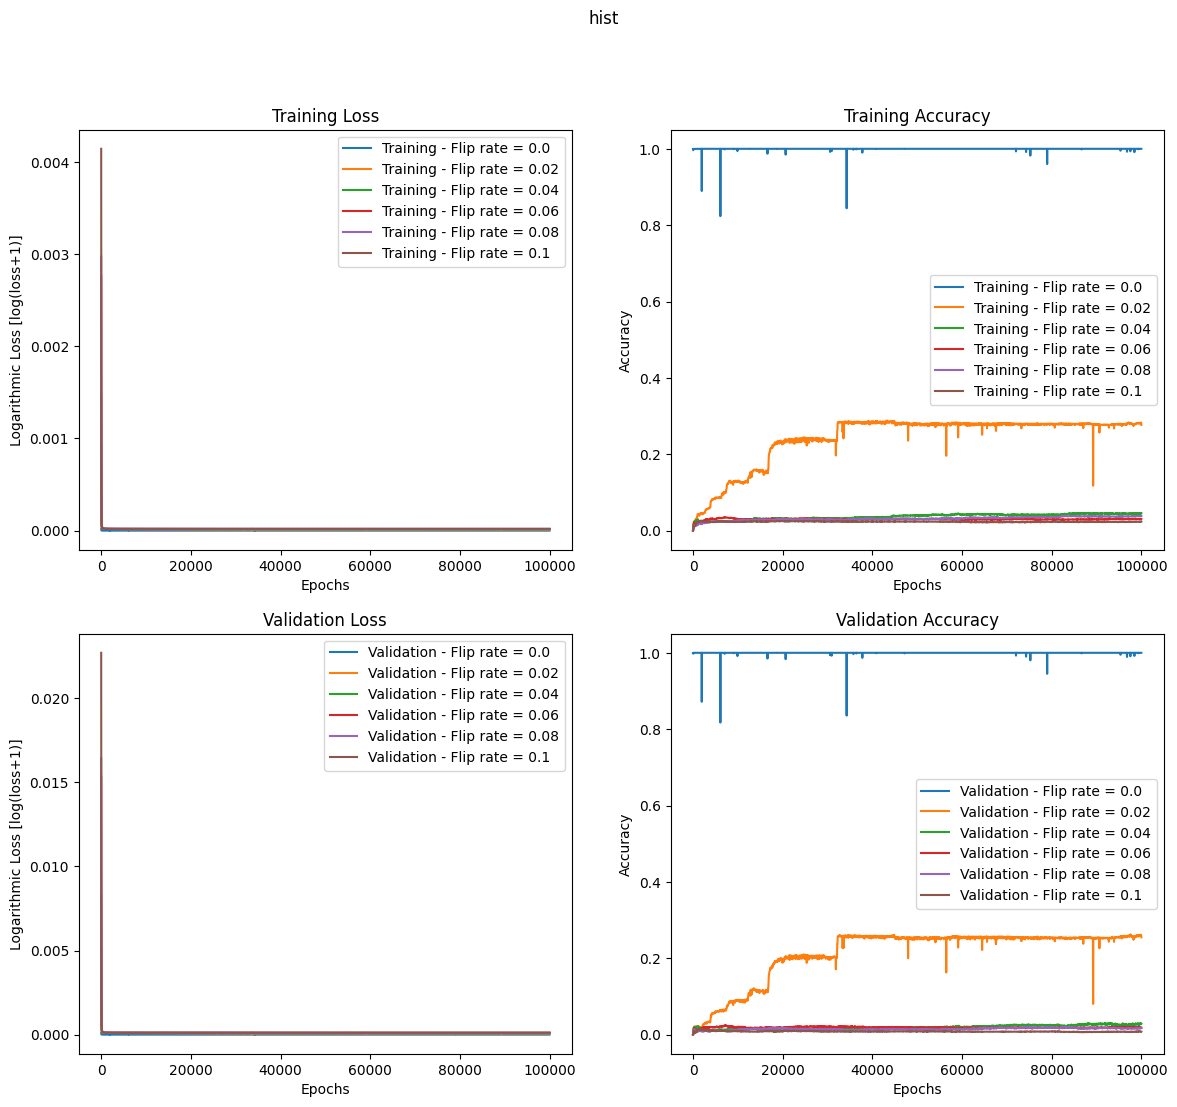

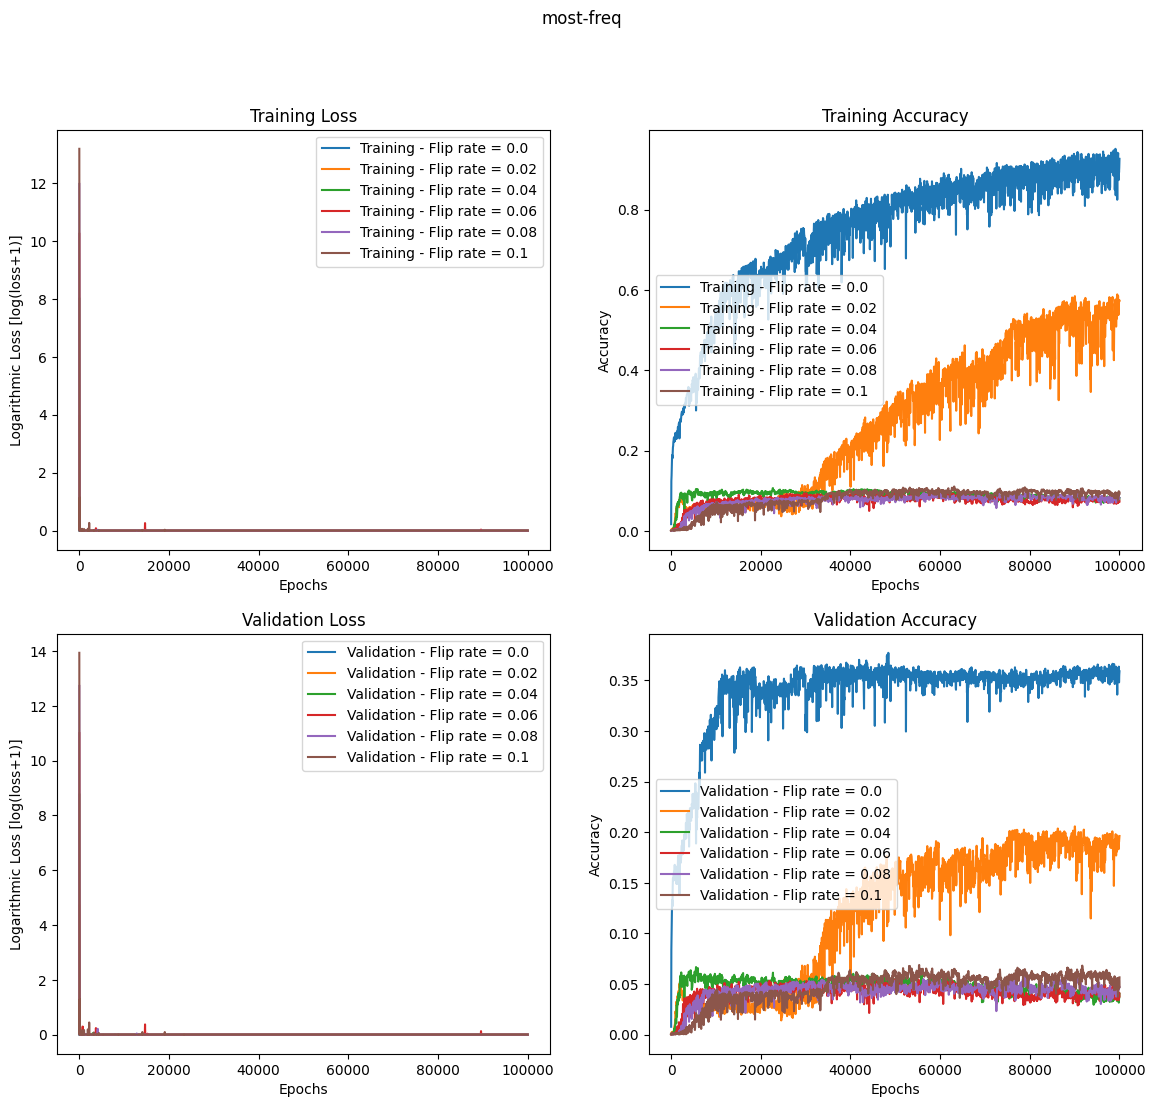

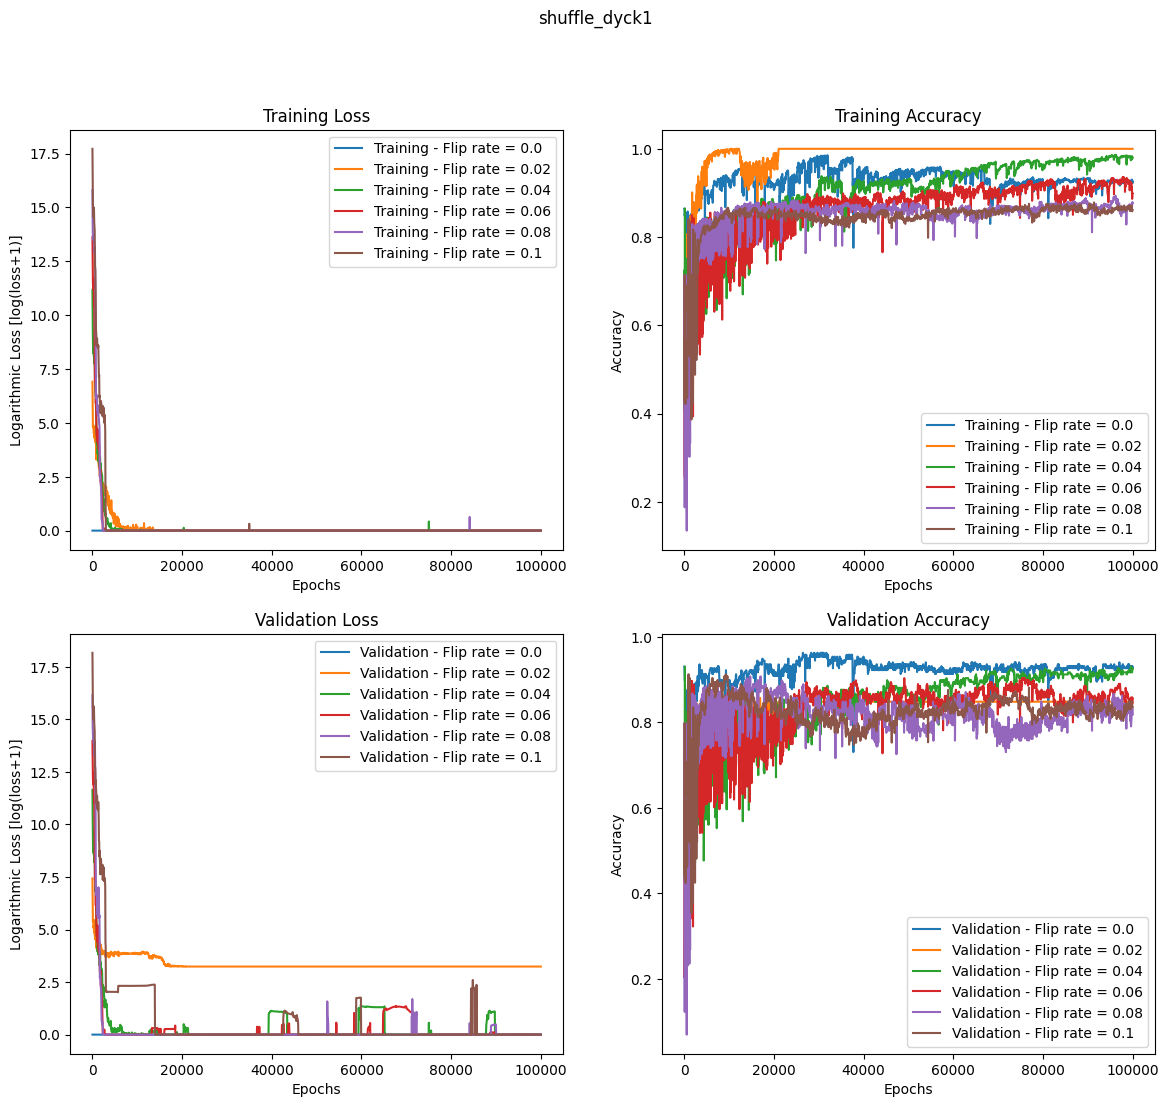

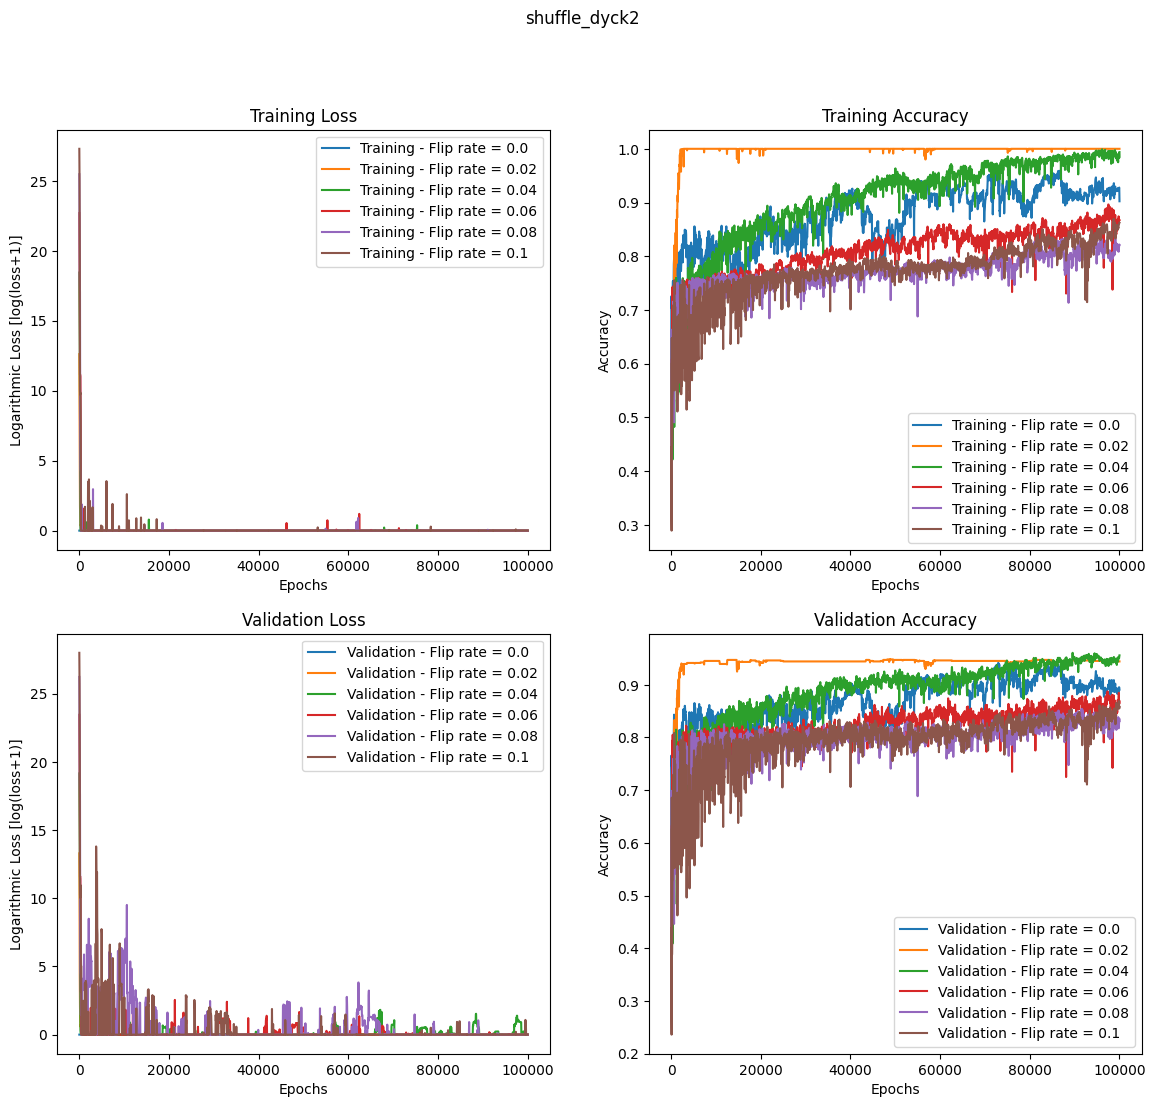

In [27]:
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/noiseTrainingBitFlip/"
stdMode = None
displayResults(baseDirectory, "sort", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, useLogLoss=True)
displayResults(baseDirectory, "reverse", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, useLogLoss=True) 
displayResults(baseDirectory, "hist", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, useLogLoss=True)
displayResults(baseDirectory, "most-freq", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, useLogLoss=True) 
displayResults(baseDirectory, "shuffle_dyck1", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, useLogLoss=True)
displayResults(baseDirectory, "shuffle_dyck2", consideredParams = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], noiseType="bitflip", stdMode=stdMode, useLogLoss=True)